<a href="https://colab.research.google.com/github/AllieUbisse/end-to-end-ml/blob/master/notebooks/end_to_end_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
# Data extraction
import os
import tarfile
from six.moves import urllib

# Data manipulation
import pandas as pd
import numpy as np

# visualization 
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Data Preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# modeling
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Data Gathering or loading

In [0]:

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        urllib.request.urlretrieve(housing_url, tgz_path)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()

In [0]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [0]:
fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH)
housing = load_housing_data(housing_path=HOUSING_PATH)
# housing.to_csv('housing.csv')


# EDA

In [5]:
# view the 1st 5 observations
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
print('Housing data Columns(Attributes) = ', housing.shape[0])
print('Housing data Rows(observations)  = ', housing.shape[1])

Housing data Columns(Attributes) =  20640
Housing data Rows(observations)  =  10


In [12]:
# view the info about the dataframe
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


**DATA TYPES**:

**9 columns** are **numeric** including except **ocean_proximity** is an **object** 


 **NULL VALUES**:

 we have **20640 observations** in total

 but **total_bedrooms**  is having only **20433** meaning we have **207 null values**


In [11]:
# checking the cardinality of ocean_proximity categorical
housing['ocean_proximity'].value_counts(dropna=False)

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

We observe that **ocean_proximity** is having a **cardinality = 5**

In [15]:
# checking the summary statistics
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


we observe that the **median_house_value** is having a **mean = 206855.816909** this will help during model evaluation.


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

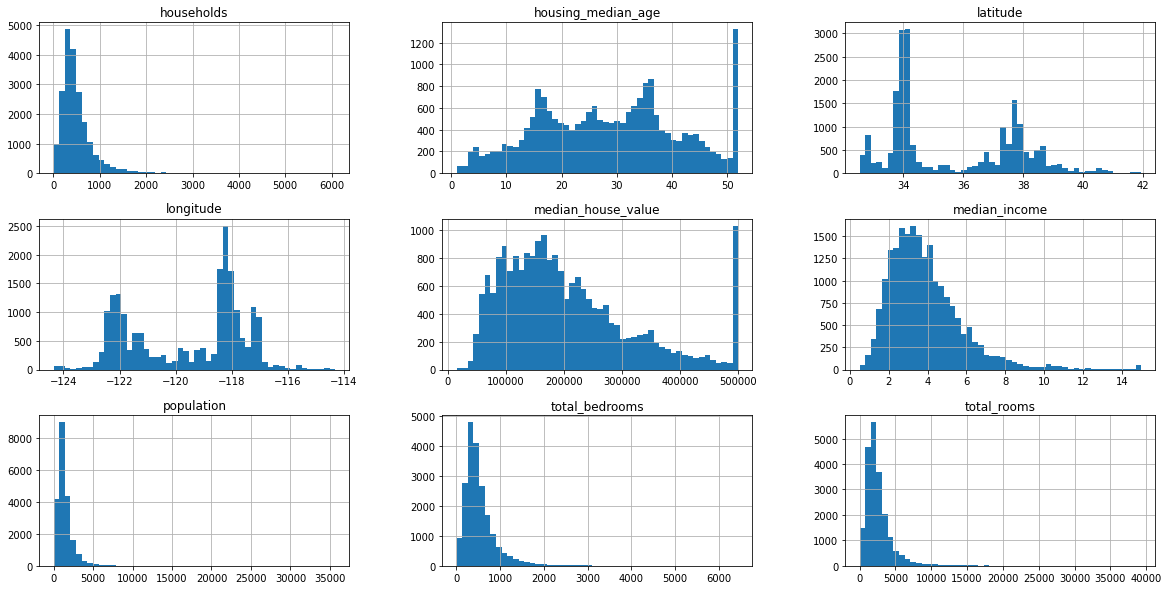

In [14]:
# Visualizing the numeric features to check the distributions (normal, left or right skewed)
housing.hist( bins=50, figsize=(20,10))
plt.show()

We observe that most of the features are Right skewed!

- We might need to transform the skewed features so the can follow a nornal distribution as per linear model asssumption.



**Create a Test Set and Train set**
- Before we go futher with the analysis or data manipulation, **we need to split the data into train and test.**
- This is done to reduce biss, since we can recognize parttens and select the algorithm we think will perform better without testing **(bias model selection)**
- We are going to set  **70% subset for train and 30% test**

In [19]:
# Spliting data into train and test subsets
train_set, test_set = train_test_split(housing, test_size=0.20, random_state=42)

# View the shape of train_set and test_set
train_set.shape, test_set.shape

((16512, 10), (4128, 10))

**Custom Split to reduce the skewness from random sampling**

In [0]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1, 2, 3, 4, 5])

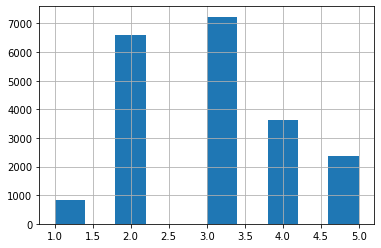

In [21]:
housing["income_cat"].hist()

In [0]:
# defining the StratifiedShuffleSplit instance
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# spliting the data into train and test using stratified method
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set =  housing.loc[test_index]




In [0]:
# removing the income_cat
for set_ in (strat_train_set, strat_test_set):
  set_.drop('income_cat', axis=1, inplace= True)

In [0]:
# copy the dataframe to avoid manipulation the original data
train = strat_train_set.copy()
test = strat_test_set.copy()

In [41]:
train.columns.to_list()

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

# **EDA Plus**  



**Visualizing Geographical Data**

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

<Figure size 432x360 with 0 Axes>

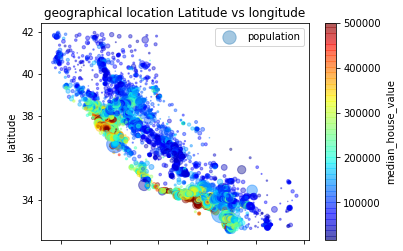

In [102]:
# set figure size
plt.figure(figsize=(6,5))

# visualizing the geographical locations by the sea
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
              s=housing["population"]/100, label="population", 
              c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
              )
plt.legend()

plt.title('geographical location Latitude vs longitude' )

plt.show()

**Lookig at Numeric Features**
- Correlation of features with the  target/label
- Correlation within the features themselves (Multicolinearity)



In [103]:
# computing the correlation matrix
corr_matrix = train.corr()

# displaying correlation with respect to the target
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

**The correlation coefficient ranges from –1 to 1.** 
 
 - we can clearly see that **median_income** is **highly correlated** with the **target** with a **strong positive correlation** of **0.687160**

- The rest are not that correlated with the target!

- When the coefficient is close to –1, it means
that there is a **strong negative correlation**; you can see a small negative correlation
between the **latitude** and the **median house value** (i.e., prices have a slight tendency to go down when you go north).

- coefficients **close to zero** mean that there is no linear correlation


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

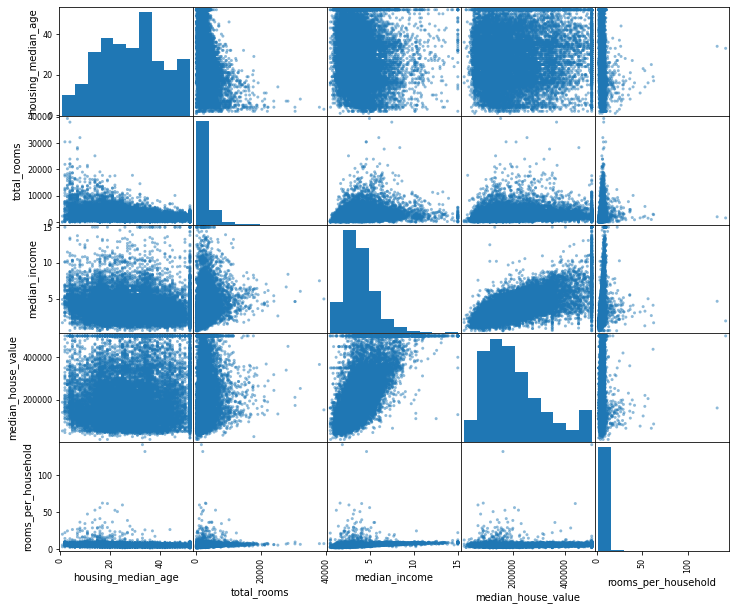

In [104]:
# set the attributes which are better correlated with the median house value (target)
cols_of_value = corr_matrix [corr_matrix['median_house_value'] > 0.1 ].index.tolist()

# plot the scatter matrix to check multicolinearity
scatter_matrix(train[cols_of_value], figsize=(12,10))
plt.show()

**Multicolinearity** report
- The features are not having a clear correlation with each other.
- futher investigation should be done using the stats model during feature selection.


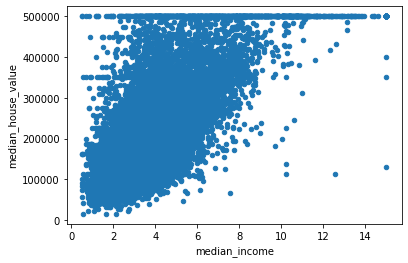

In [105]:
# Lest Zoom into the median house value vs median income
train.plot(kind='scatter', x='median_income', y='median_house_value')

we can see how median income affect the median house value, as the median income increase the value of the house increases.

- The values are capped at **500 000 , 450 000 and 350 000** this is shown by the straight line appearing at those price points.

- such values might affect our model in the future. 

# FEATURE ENGINEERING
- Experimenting with Attribute Combinations
- Recheck correlation with the target.


In [0]:
train["rooms_per_household"] = train["total_rooms"]/train["households"]
train["bedrooms_per_room"] = train["total_bedrooms"]/train["total_rooms"]
train["population_per_household"]=train["population"]/train["households"]

In [126]:
# rechecking the correlation
corr_matrix2 = train.corr()

# comparing the correlation effect before and after
print('BEFORE attribute combination correlation \n', corr_matrix['median_house_value'].sort_values(ascending=False))
print('\n AFTER attribute combination correlation \n', corr_matrix2['median_house_value'].sort_values(ascending=False))


BEFORE attribute combination correlation 
 median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

 AFTER attribute combination correlation 
 median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room    

# **Prepare the Data for Machine Learning Algorithms**
We make use of machine learning pipeline to do the data preprocessing steps. This is done to reduce code and for readability & reusability.



In [0]:
# replace the modified train with the strat_train_set
#train = strat_train_set.copy()

# separate features and the label from the train subset
X = strat_train_set.drop('median_house_value', axis=1)
y = strat_train_set['median_house_value'].copy()

# separate features and the label from the test subset
X_test = test.drop('median_house_value', axis=1)
y_test = test['median_house_value'].copy()


## missing values & encoding recheck

In [128]:
# Get the % of the missing values
X.isnull().mean()

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        0.009569
population            0.000000
households            0.000000
median_income         0.000000
ocean_proximity       0.000000
dtype: float64

**missing values will be**

**bedrooms_per_room** =          0.009569 in the future!

**total_bedrooms**    =           0.009569

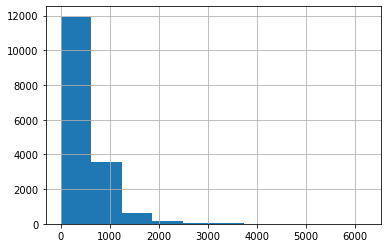

In [121]:
# ploting the distribution of the features with missing values.
X['total_bedrooms'].hist(figsize=(6,4))

The results are skewed to the right, it's better we use the **median** instead of  **mean** since it is affected by the **extreme values or outliers**

**Categorical feature**
- if the **cardinality** is **less than 25** and values are **norminal** we use **one hot encoding**

In [122]:
X.ocean_proximity.value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

# ML Pipeline

- Deal with ***Numeric Features*** (numeric_transformer = **Pipeline**):
  - missing values ( **SimpleImputer** ) for **total_bedrooms**
  - Feature scaling since most features are skewed and is required for linear regression (**StandardScaler** / **MinMaxScaler**)
  - more ?
- Dealing with ***categorical features*** (categorical_transformer = **Pipeline**):
  - missing values, if any (**most_frequent** / **constant** = 'missing')
  - Encoding the values (**OneHotEncoding** / **OrdinalEncoding** )

- Binding the two transformers using the sklearn **ColmnTransformer**:
    
    **transformers**
  - numeric_preprosesor -> ***numeric_transformer***
  -categoric_preprosessor -> ***categorical_transformer***

## *data preprocessing pipeline*

In [0]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  
        def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
            self.add_bedrooms_per_room = add_bedrooms_per_room


        def fit(self, X, y=None):
            return self # nothing else to do


        def transform(self, X, y=None):

            rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
            population_per_household = X[:, population_ix] / X[:, households_ix]

            if self.add_bedrooms_per_room:
                bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
                return np.c_[X, rooms_per_household, population_per_household,
                bedrooms_per_room]
            else:
                return np.c_[X, rooms_per_household, population_per_household]
                

In [0]:
 attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs

In [0]:
# Set the numeric and categorical columns
# we are using the train since it has the additional features we will create using the pipeline
numeric_cols = X.select_dtypes(exclude='object').columns.to_list()
#numeric_cols.remove('median_house_value')
categoric_cols = train.select_dtypes(exclude='number').columns.to_list()

# numeric data preprocessing
numeric_transformer = Pipeline(steps=[
                                    ('imputer', SimpleImputer(strategy='median')),
                                    ('attribs_adder', CombinedAttributesAdder()),
                                    ('scaler', StandardScaler())
                                    ])

# categorical data preprocessing
categoric_transformer = OneHotEncoder()

## Creat Models

In [0]:
# Linear Regression model
lin_reg = LinearRegression()

# Decision Tree Regressor model
tree_reg = DecisionTreeRegressor()

# Random Forest Rgressor model
rf_reg = RandomForestRegressor()

## **Final machine learning pipeline**

In [0]:
# Bindle the two preprocessing subpipelines
preprocessor = ColumnTransformer(transformers=[
                                               ('numeric_preprocessor', numeric_transformer, numeric_cols),
                                               ('categoric_preprocessor', categoric_transformer, categoric_cols),
                                               
                                            ]) 


In [0]:
# FIT AND TRANSFORM X FOR TRAIN SET
X_train = preprocessor.fit_transform(X)

# ONLY TRANSFORM X_TEST SET
X_test = preprocessor.transform(X_test)



# Training and Evaluating on the Training Set

In [151]:
lin_reg.fit(X_train, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Better Evaluation Using Cross-Validation

In [0]:
def display_cross_val_score(model, X, y, scoring="neg_mean_squared_error"):

    # cross_val_score
    scores  = cross_val_score(model,
                              X,
                              y,
                              scoring="neg_mean_squared_error", 
                              cv=10)
    
    scores = np.sqrt(-scores)

    print('\n\nCROSS VAL Performance measure:\n {b} \n\nScores:\n {c} \n\nMean: {d} \n\nStandard deviation: {e}\n'.format(b=scoring,
                                                                                                 c=scores,
                                                                                                  d=scores.mean(),
                                                                                                  e=scores.std()
                                                                                                  ))


def mean_SE_score(model, X=X_train, y=y):
  model.fit(X, y)
  mse = np.sqrt(mean_squared_error(y, model.predict(X)))
  print('mean_squared_error Score:',mse)

In [207]:

mean_SE_score(tree_reg, X=X_train, y=y)
display_cross_val_score(tree_reg, X= X_train, y=y)


mean_squared_error Score: 0.0


CROSS VAL Performance measure:
 neg_mean_squared_error 

Scores:
 [69096.57219795 67345.6075172  71499.14066932 68902.03595402
 69567.48886435 75336.82759237 71095.29205023 70741.18394656
 76244.90957766 69883.34250781] 

Mean: 70971.24008774747 

Standard deviation: 2670.433925660464



In [208]:
mean_SE_score(lin_reg, X=X_train, y=y)
display_cross_val_score(lin_reg, X= X_train, y=y )


mean_squared_error Score: 68628.19819848923


CROSS VAL Performance measure:
 neg_mean_squared_error 

Scores:
 [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067] 

Mean: 69052.46136345083 

Standard deviation: 2731.674001798344



In [211]:
mean_SE_score(rf_reg, X=X_train, y=y)
display_cross_val_score(rf_reg, X= X_train, y=y)

mean_squared_error Score: 18695.66635975615


CROSS VAL Performance measure:
 neg_mean_squared_error 

Scores:
 [49377.25103962 47919.71840356 49972.01836998 52244.0069414
 49328.72522289 53627.55925156 48826.87148813 47994.44465358
 52903.52478137 50503.01455454] 

Mean: 50269.7134706627 

Standard deviation: 1916.1430753273114

